# Desc

- using this file to practice/learn basic stats
- also want to learn standard time series analysis techniques

In [1]:
from IPython.display import display, HTML
import ipywidgets as widgets
from ipywidgets import interact
display(HTML("<style>.container { width:75% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.ar_model import AutoReg

from sklearn.metrics import r2_score

In [4]:

def check_stationary(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.01) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [39]:
# parameters
_round_num = 4
_time_per_day = 1000000

In [40]:
def get_file_trades(day):
    fname = f"../data/round5/trades_round_{_round_num}_day_{day}_wn.csv"
    print("fname", fname)
    return pd.read_csv(fname, sep=";")


def get_file_prices(day):
    fname = f"../data/round{_round_num}/prices_round_{_round_num}_day_{day}.csv"
    print("fname", fname)
    return pd.read_csv(fname, sep=";")

def get_symbol_prices(symbol, days):
    """ Returns DataFrame containing all price data for specified symbol, over the specified 'days'
    If symbol is None, don't filter on symbol
    """
    
    data = []
    for day in days:
        price_df = get_file_prices(day)
        data += [price_df]
    
    # concat
    price_df = pd.concat(data)
    
    # rename "bid" to "buy"
    # rename "ask" to "sell"
    price_df = price_df.rename({col: col.replace("bid", "buy") for col in price_df.columns if "bid" in col}, axis=1)
    price_df = price_df.rename({col: col.replace("ask", "sell") for col in price_df.columns if "ask" in col}, axis=1)
    price_df = price_df.rename({"timestamp": "time", "product": "symbol"}, axis=1)
    
    if symbol is not None:
        # filter for specific symbol
        price_df = price_df[price_df["symbol"] == symbol]
    
    # fix times, sort by time and reindex
    price_df["time"] = price_df["time"] + (price_df["day"] - min(days)) * _time_per_day
    price_df = price_df.sort_values(by="time").reset_index(drop=True)
    
    return price_df

def get_symbol_trades(symbol, days):
    data = []
    for day in days:
        price_df = get_file_trades(day)
        price_df["day"] = day
        data += [price_df]
    
    # concat
    price_df = pd.concat(data)
    price_df = price_df.rename({"timestamp": "time", "product": "symbol"}, axis=1)
    
    if symbol is not None:
        # filter for specific symbol
        price_df = price_df[price_df["symbol"] == symbol]
    
    # fix times, sort by time and reindex
    price_df["time"] = price_df["time"] + (price_df["day"] - min(days)) * _time_per_day
    price_df = price_df.sort_values(by="time").reset_index(drop=True)
    
    return price_df
    


def get_all_mids(days):
    price_df = get_symbol_prices(symbol=None, days=days)
    
    symbols = set(price_df["symbol"])
    
    price_df["mid"] = (price_df["buy_price_1"] + price_df["sell_price_1"]) / 2
    
    return price_df[["time", "symbol", "mid"]].copy()

In [41]:
def get_book_large_size(price_df, side):
    """ 
    side = 'buy' or 'sell' 
    
    Returns prices, sizes
    """
    
    book_range = list(range(1, 3+1))
    
    # get bids
    bid_sizes = price_df[[f"{side}_volume_{i}" for i in book_range]]
    bid_prices = price_df[[f"{side}_price_{i}" for i in book_range]]

    # replace nan with -1
    bid_sizes = bid_sizes.replace(np.nan, -1)

    # find inds
    inds = np.argmax(bid_sizes.to_numpy(), axis=1)

    # filter to keep largest bids
    bid_prices = bid_prices.to_numpy()[np.arange(len(bid_prices)), inds]
    bid_sizes = bid_sizes.to_numpy()[np.arange(len(bid_sizes)), inds]
    
    # create dataframe
    df = pd.DataFrame([bid_prices, bid_sizes]).T
    df.columns = [f"{side}_price", f"{side}_size"]
    df["time"] = price_df["time"].reset_index()["time"]
    df["symbol"] = price_df["symbol"]
    
    return df


def get_whale_quotes(price_df):
    # get big buy/sell quotes
    buy_df = get_book_large_size(price_df, "buy")
    sell_df = get_book_large_size(price_df, "sell")

    # create big quote_df
    quote_df = pd.merge(buy_df, sell_df, on=["time", "symbol"])
    quote_df["mid_price"] = (quote_df["buy_price"] + quote_df["sell_price"]) / 2
    quote_df["spread"] = quote_df["sell_price"] - quote_df["buy_price"]

    return quote_df

# Counterparty analysis

In [42]:
# load data
# _day_range = [-2, -1, 0]
# _day_range = [-1, -0, 1]
# _day_range = [0,1, 2]
_day_range = [1, 2, 3]
trade_df = get_symbol_trades(None, days=_day_range)
price_df = get_symbol_prices(None, days=_day_range)
price_df = get_whale_quotes(price_df)
_symbols = set(trade_df["symbol"])


# compute all_mid_Df
all_dfs = []

for sym in _symbols:
    df = price_df[price_df["symbol"] == sym]
    
    datas = {
        "time": df["time"],
        "mid": df["mid_price"],
        "symbol": df["symbol"]
    }

    for i in [1, 3, 10, 30, 100, 300, 1000, 3000, 5000]:
        datas[f"d_{i}"] = -1 * df["mid_price"].diff(-1 * i)

    all_dfs += [pd.DataFrame(datas)]

all_mid_df = pd.concat(all_dfs)

# merge into trade_df
trade_df = trade_df.merge(all_mid_df, on=["symbol", "time"])
trade_df["sell_edge"] = trade_df["price"] - trade_df["mid"]

fname ../data/round5/trades_round_4_day_1_wn.csv
fname ../data/round5/trades_round_4_day_2_wn.csv
fname ../data/round5/trades_round_4_day_3_wn.csv
fname ../data/round4/prices_round_4_day_1.csv
fname ../data/round4/prices_round_4_day_2.csv
fname ../data/round4/prices_round_4_day_3.csv


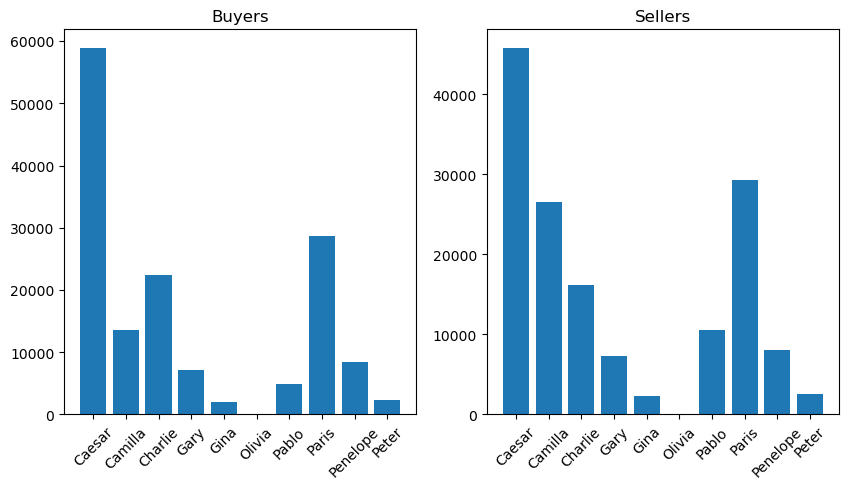

In [43]:
# general plot of data
total_buys = trade_df.groupby(["buyer"])[["quantity"]].sum()
total_sells = trade_df.groupby(["seller"])[["quantity"]].sum()

plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.bar(total_buys.index, total_buys["quantity"])
plt.xticks(rotation=45)
plt.title("Buyers")

plt.subplot(122)
plt.bar(total_sells.index, total_sells["quantity"])
plt.xticks(rotation=45)
plt.title("Sellers")
plt.show()

In [44]:
df1 = trade_df.groupby(["symbol", "buyer"])["quantity"].agg(["sum", "count"])
df2 = trade_df.groupby(["symbol", "seller"])["quantity"].agg(["sum", "count"])

df1 = df1.reset_index().rename({"buyer": "party", "sum": "buy_vol", "count": "buy_count"}, axis=1)
df2 = df2.reset_index().rename({"seller": "party", "sum": "sell_vol", "count": "sell_count"}, axis=1)

vol_df = df1.merge(df2, on=["symbol", "party"], how="outer")

for sym in _symbols:
    df = vol_df[vol_df["symbol"] == sym].sort_values(by="buy_vol", ascending=False)
#     df = df[(df["buy_count"] < 20)]
#     display(df.drop(["buy_count", "sell_count"], axis=1))
    display(df)

,symbol,party,buy_vol,buy_count,sell_vol,sell_count
40,PICNIC_BASKET,Camilla,2110,427,1627,293
42,PICNIC_BASKET,Penelope,1350,380,1331,387
41,PICNIC_BASKET,Pablo,1069,388,1705,588
39,PICNIC_BASKET,Caesar,934,563,800,490


,symbol,party,buy_vol,buy_count,sell_vol,sell_count
43,PINA_COLADAS,Caesar,5830,360,5307,302
44,PINA_COLADAS,Charlie,1437,229,408,112
46,PINA_COLADAS,Peter,631,177,712,208
45,PINA_COLADAS,Pablo,318,34,1789,178


,symbol,party,buy_vol,buy_count,sell_vol,sell_count
0,BAGUETTE,Caesar,10205,1720,6187,1140
2,BAGUETTE,Paris,6226,1147,6589,1193
1,BAGUETTE,Camilla,33,6,3688,540


,symbol,party,buy_vol,buy_count,sell_vol,sell_count
33,PEARLS,Charlie,4426,1773,4400,1728
37,PEARLS,Paris,2598,2229,2526,2197
36,PEARLS,Pablo,1643,648,1781,688
32,PEARLS,Camilla,1587,742,1450,689
34,PEARLS,Gary,1529,290,1433,280
38,PEARLS,Penelope,1522,503,1599,549
31,PEARLS,Caesar,1219,859,1303,907
35,PEARLS,Gina,544,131,576,137


,symbol,party,buy_vol,buy_count,sell_vol,sell_count
28,DIVING_GEAR,Camilla,1516,788,1903,970
30,DIVING_GEAR,Paris,1444,725,1445,737
29,DIVING_GEAR,Charlie,1172,600,784,406


,symbol,party,buy_vol,buy_count,sell_vol,sell_count
21,COCONUTS,Caesar,18330,463,18928,473
22,COCONUTS,Charlie,4924,324,1230,162
24,COCONUTS,Peter,1592,210,1705,221
23,COCONUTS,Pablo,776,45,3759,186


,symbol,party,buy_vol,buy_count,sell_vol,sell_count
25,DIP,Caesar,15645,2186,8217,1191
27,DIP,Paris,8403,1224,8793,1254
26,DIP,Camilla,152,26,7190,991


,symbol,party,buy_vol,buy_count,sell_vol,sell_count
12,BERRIES,Camilla,6749,739,7195,812
19,BERRIES,Penelope,2840,248,2549,223
18,BERRIES,Paris,2727,503,2382,430
14,BERRIES,Gary,2154,152,2355,165
13,BERRIES,Charlie,251,21,315,32
17,BERRIES,Pablo,175,29,83,18
20,BERRIES,Peter,146,51,170,58
15,BERRIES,Gina,90,12,83,16
16,BERRIES,Olivia,51,4,51,5


,symbol,party,buy_vol,buy_count,sell_vol,sell_count
47,UKULELE,Caesar,5966,1609,4204,1407
50,UKULELE,Paris,4207,1408,4021,1326
48,UKULELE,Camilla,14,6,1962,290
49,UKULELE,Olivia,9,3,9,3


,symbol,party,buy_vol,buy_count,sell_vol,sell_count
5,BANANAS,Charlie,10176,3047,9065,2510
6,BANANAS,Gary,3515,304,3536,316
10,BANANAS,Paris,3137,2687,3485,3100
11,BANANAS,Penelope,2648,467,2560,497
4,BANANAS,Camilla,1491,735,1500,765
7,BANANAS,Gina,1443,217,1677,277
9,BANANAS,Pablo,911,389,1432,561
3,BANANAS,Caesar,795,634,861,452
8,BANANAS,Olivia,51,4,51,6


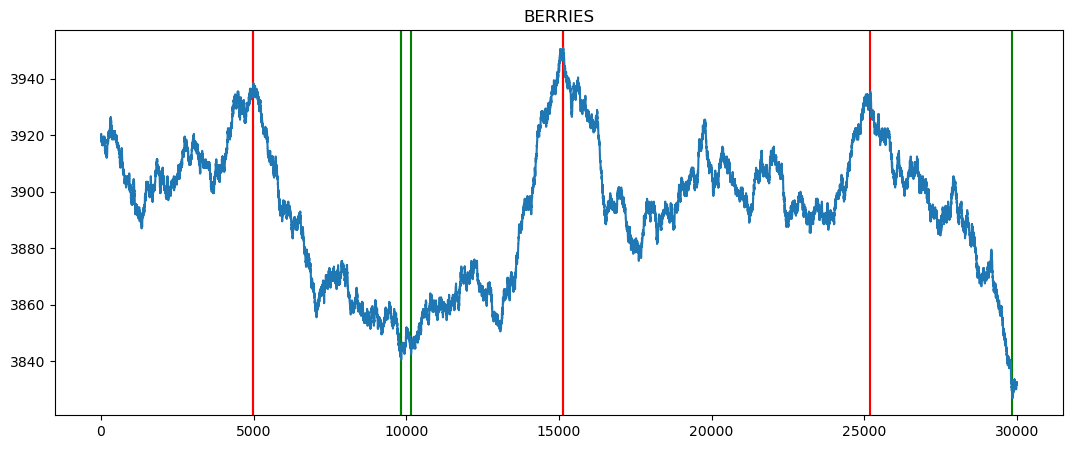

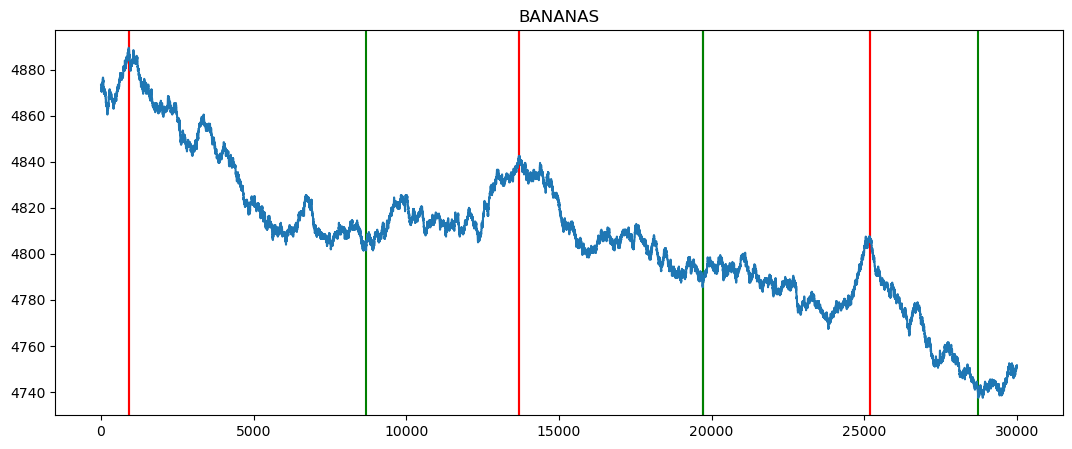

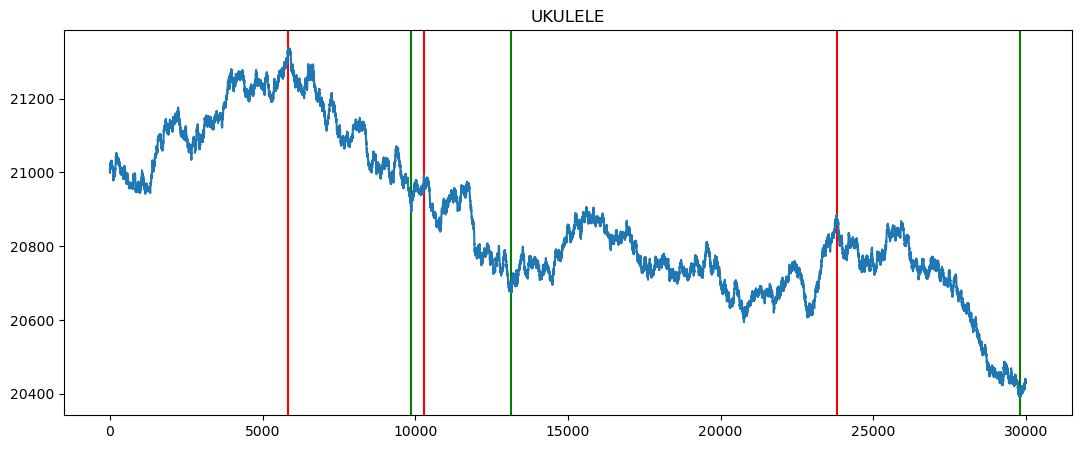

In [51]:
party = "Olivia"

party_trades = trade_df[(trade_df["buyer"] == party) | (trade_df["seller"] == party)]

syms = set(party_trades["symbol"])

for sym in syms:
    plt.figure(figsize=(13, 5))
    df = price_df[price_df["symbol"] == sym].reset_index()
    
    tdf = party_trades[party_trades["symbol"] == sym]
    

    for index, row in tdf.iterrows():
        is_buy = row["buyer"] == party
#         if not is_buy:
#             continue
        color = "green" if is_buy else "red"
        time = row["time"] // 100
        plt.axvline(x=time, color=color)
    
    plt.plot(df["mid_price"])

    plt.title(sym)
    plt.show()

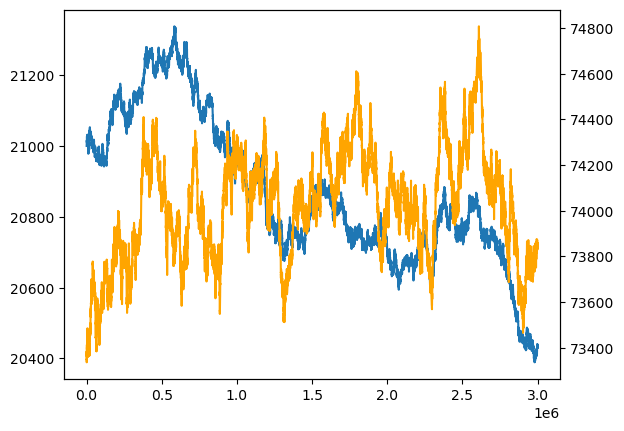

In [57]:
ax = plt.gca()
df = price_df[price_df["symbol"] == "UKULELE"]
ax.plot(df["time"], df["mid_price"])



df = price_df[price_df["symbol"] == "PICNIC_BASKET"]
ax.twinx().plot(df["time"], df["mid_price"], color="orange")


In [ ]:

plt.plot(price_df[''])

# General Analysis Strategy
- find who is making the most money
- find their most profitable types of trades
    - filter by symbols + buy/sell side
    - map their return after 1, 3, 10, 30, ... turns

In [49]:
cols = ["count", "sell_edge"] + [col for col in trade_df.columns if col.startswith("d_")]
sort_by = "d_100"

# in buyers, most positive is best
counts = trade_df.groupby(["buyer", "symbol"])["time"].count()
buys = trade_df.groupby(["buyer", "symbol"]).mean()
buys["count"] = counts
display(buys[cols].sort_values(by=sort_by, ascending=False))
# display(buys[cols])

# in sellers, most negative is best
counts = trade_df.groupby(["seller", "symbol"])["time"].count()
sells = trade_df.groupby(["seller", "symbol"]).mean()
sells["count"] = counts
display(sells[cols].sort_values(by=sort_by, ascending=True))


count  sell_edge       d_1       d_3       d_10  \
buyer    symbol                                                           
Olivia   UKULELE            3   0.666667  4.333333  8.333333  14.000000   
Camilla  UKULELE            6   0.000000  0.500000 -1.500000   0.333333   
         DIVING_GEAR      788  -0.522208  0.078046 -0.068615   0.822519   
Olivia   BANANAS            4   3.000000  0.250000  0.750000   2.500000   
         BERRIES            4   2.125000  0.750000  0.750000   3.125000   
Camilla  DIP               26  -0.038462  0.019231  0.096154   0.288462   
Charlie  DIVING_GEAR      600  -1.500833  0.357500  0.460000  -0.055833   
Paris    BAGUETTE        1147   0.795990  0.060593  0.066696   0.386998   
Pablo    PINA_COLADAS      34   0.176471  0.205882  0.338235   0.602941   
Gina     BERRIES           12  -0.125000  0.333333 -0.041667   0.166667   
Paris    DIVING_GEAR      725   1.241379  0.131724 -0.030345  -0.195862   
Caesar   DIP             2186  -0.796432 -0.031336  0.061070   0.077574   
         BAGUETTE        1720  -0.712500 -0.079651  0.130814   0.228330   
Charlie  BERRIES           21  -4.047619 -0.190476 -0.333333   0.095238   
Peter    PINA_COLADAS     177   1.257062  0.276836  0.533898   0.731638   
Pablo    COCONUTS          45   0.255556 -0.177778 -0.155556   0.066667   
Penelope BERRIES          248   3.221774 -0.046371 -0.098790  -0.062500   
Paris    DIP             1224   0.840278  0.037990 -0.000817   0.043301   
Charlie  PEARLS          1773  -2.800620  0.140237  0.139391   0.145034   
Caesar   PEARLS           859  -3.658906  0.042491  0.043706   0.029720   
Gary     BANANAS          304   2.555921  0.059211  0.003289   0.110197   
Camilla  PEARLS           742  -1.988544  0.007412  0.023585   0.036437   
Caesar   BANANAS          634  -2.385647  0.203470  0.254732   0.198262   
Gary     PEARLS           290   3.482759 -0.006897 -0.060345  -0.027586   
Penelope PEARLS           503   3.496024 -0.016899 -0.016899   0.005964   
Peter    BERRIES           51  -0.343137  0.107843 -0.078431  -0.058824   
Paris    PEARLS          2229   2.434051 -0.090399 -0.092867  -0.073384   
Caesar   COCONUTS         463  -0.501080  0.456803  0.263499   0.392009   
Pablo    PEARLS           648   1.760802 -0.229167 -0.253858  -0.224537   
Peter    COCONUTS         210   1.240476  0.030952  0.107143   0.352381   
Camilla  BERRIES          739  -3.401218  0.006089 -0.014885  -0.023004   
Gina     PEARLS           131   0.931298 -0.312977 -0.328244  -0.316794   
Charlie  COCONUTS         324  -1.470679 -0.084877 -0.143519  -0.233025   
Gina     BANANAS          217   0.811060 -0.050691 -0.076037  -0.096774   
Penelope BANANAS          467   2.483940 -0.051392 -0.114561  -0.175589   
Charlie  BANANAS         3047  -2.887923 -0.032983 -0.052035  -0.033333   
Camilla  BANANAS          735  -2.665306 -0.024490 -0.011565  -0.048299   
Pablo    BANANAS          389   0.993573 -0.001289 -0.057990  -0.114691   
Paris    BANANAS         2687   2.043915 -0.026982 -0.032936  -0.052681   
Pablo    BERRIES           29  -0.241379  0.086207  0.103448   0.017241   
Paris    BERRIES          503   3.112326 -0.017893 -0.042744  -0.066733   
Gary     BERRIES          152   3.062500  0.069079  0.101974   0.065789   
Charlie  PINA_COLADAS     229  -1.537118 -0.043668  0.028384  -0.244541   
Paris    UKULELE         1408   0.673295  0.004616 -0.085227  -0.118253   
Caesar   PINA_COLADAS     360  -0.966667 -0.013889  0.055556   0.154167   
Camilla  PICNIC_BASKET    427  -6.255269  0.142857 -0.311475   0.675644   
Caesar   UKULELE         1609  -0.700435 -0.067122 -0.151958  -0.488495   
         PICNIC_BASKET    563  -5.105684  0.358792 -0.420959  -1.750000   
Camilla  BAGUETTE           6  -0.250000 -1.000000 -1.250000  -1.916667   
Pablo    PICNIC_BASKET    388   4.673969 -0.838918 -1.399485   2.027062   
Penelope PICNIC_BASKET    380   5.698684  0.768421  1.178947   0.557895   

                             d_30      d_100    

,,count,sell_edge,d_1,d_3,d_10,d_30,d_100,d_300,d_1000,d_3000,d_5000
seller,symbol,,,,,,,,,,,
Olivia,UKULELE,3,-1.000000,-2.666667,-7.333333,-11.000000,-19.666667,-47.333333,-92.000000,-96.333333,-260.666667,-344.333333
Camilla,PICNIC_BASKET,293,5.691126,-0.279863,-1.056314,-0.648464,-1.735495,-13.226962,-12.367698,-0.061837,-0.416981,49.555785
Olivia,BERRIES,5,-3.700000,-1.000000,-1.200000,-1.800000,-3.200000,-7.800000,-17.000000,-35.300000,-58.600000,-68.000000
Pablo,PICNIC_BASKET,588,-5.664966,0.147109,0.086735,-0.555272,-1.810903,-6.972743,-4.623499,-6.514286,16.475822,18.484375
Olivia,BANANAS,6,-3.000000,-0.333333,-0.666667,-0.666667,-2.333333,-5.666667,-12.333333,-23.666667,-47.666667,-64.500000
Peter,PINA_COLADAS,208,-1.331731,0.108173,0.189904,-0.137019,-0.391827,-2.098558,-1.776699,-3.174129,-8.389785,-3.701807
Paris,UKULELE,1326,-0.702866,-0.106712,-0.200603,-0.510181,-0.752640,-1.995083,-7.148021,-21.120435,-61.954962,-99.168642
Camilla,UKULELE,290,-0.662069,0.184483,0.150000,-0.256055,-0.307958,-1.865052,-6.422261,-12.523466,-43.131274,-78.936709
Caesar,PINA_COLADAS,302,-0.500000,-0.048013,0.084437,0.125828,-0.430464,-1.711667,-0.191667,-4.503413,-2.687050,-6.414122
